# Calcul des probabilités et théorie des erreurs - Projet

## Table des matières

* [Introduction]
* [Initialisation]
* [Lire les échantillons]
* [Aperçus des données fournies]
* [Moyenne et variance]
* [Allure générale des échantillons]
* [Test d'adéquation]
* [Tests d'équivalence]
    - [Test de Fisher]
    - [Test t de Student]

## Introduction
La question 6 concerne l'inversion d'une matrice en utilisant un réseau de noeuds. Cette opération est réalisée de deux manière différentes :
* Avec les noeuds en série
* Avec les noeuds en parallèle

Le temps nécessaire pour effectuer cette opération est mesuré et groupé en fonction de la taille de la matrice.


## Initialisation

In [167]:
from collections import defaultdict
import matplotlib.pyplot as plot
import scipy.stats as stats
import math

ALPHA = 0.05

def normalize(f):
    return '{:0.5f}'.format(f)

## Lire les échantillons
Le fichier '.dat' fournit contient un tableau en trois colonnes :
1. La taille des matrices exprimée en nombre de lignes
2. Le temps mesuré lors d'un travail en série
3. le temps mesuré lors d'un travail en parallèle

Ces données seront stockées dans un dictionnaire de la forme suivante :
* Clés : Tailles des matrices (50, 150, ..., 950)
* Valeurs : Tuple contenant deux listes, la première contient les temps mesurés en série et la seconde les temps mesurés en parallèle


In [168]:
def load_file(name):
    samples = defaultdict(lambda: ([], []))
    with open(name) as file:
        for l in file:
            values = list(map(float, l.split()))
            size = int(values[0])
            times = values[1:]
            for i in range(2):
                samples[size][i].append(times[i])
        for size, times in samples.items():
            times[0].sort()
            times[1].sort()
        return samples

SAMPLES = load_file("Q6_donnee.dat")

## Aperçus des données fournies

Un premier graphique sous la forme d'un nuage de points parait un bon point de départ.
En effet, il permet d'avoir un premier aperçu du comportement des deux techniques en fonction de la taille des matrices.

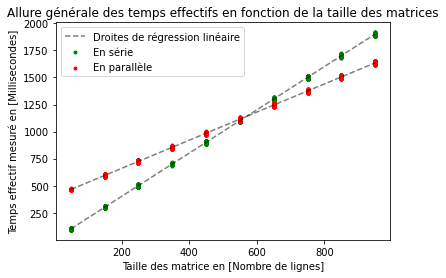

In [169]:
def overview_of_data():
    x = []
    y1 = []
    y2 = []
    for size, times in SAMPLES.items():
        for t1, t2 in zip(times[0], times[1]):
                x.append(size)
                y1.append(t1)
                y2.append(t2)
    plot.scatter(x, y1, c='green', label='En série', marker='.')
    plot.scatter(x, y2, c='red', label='En parallèle', marker='.')
    #plot.legend()
    #plot.savefig('fig_1.png')
    plot.plot(x, linear_regression(x, y1), label='Droites de régression linéaire', ls='--', c='k', alpha=0.5)
    plot.plot(x, linear_regression(x, y2), ls='--', c='k', alpha=0.5)
    plot.legend()
    #plot.savefig('fig_2.png')
    plot.title('Allure générale des temps effectifs en fonction de la taille des matrices')
    plot.xlabel('Taille des matrice en [Nombre de lignes]')
    plot.ylabel('Temps effectif mesuré en [Millisecondes]')
    plot.show()

def linear_regression(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    res = []
    for x_i in x:
        res.append(slope * x_i + intercept)
    return res

overview_of_data()

Au vue de ce graphique, il est possible de tirer de premières conclusions :
* Dans les deux cas, le temps nécessaire augmente de proportionnellement avec la taille de la matrice
* Quand la taille est petite ($< \pm 550$), le travail en série semble plus performant que le travail en parallèle
* Par la suite, la situation s'inverse

## Moyenne et variance
Par la suite du projet, il sera nécessaire d'obtenir la moyenne et la variance d'un ensemble de données.
Donc voici deux fonctions permettant de calculer la moyenne empirique et la variance non biaisée.

Pour rappel, dans le cas d'estimateurs non biaisés la moyenne non biaisée est égale à la moyenne empirique.

In [170]:
def empirical_mean(data):
    return sum(data) / len(data)

def unbiased_variance(data):
    res_sum = 0
    xn = empirical_mean(data)
    for x in data:
        res_sum += (x - xn)**2
    return res_sum / (len(data) - 1)

def construct_means_var():
    res = defaultdict(lambda: [float, float, float, float]) #{int (size) : [float (mu série], float (mu par), float (var série), float (var par)}
    for size, times in SAMPLES.items():
        for i in range(2):
            res[size][i] = empirical_mean(times[i])
            res[size][i+2] = unbiased_variance(times[i])
    return res

MEANS_VAR = construct_means_var()

def print_means_var():
    builder = " N  |       Moyennes        |   Variances\n"
    builder += "    |   Série   |   Paral   |   Série   |   Paral   \n"
    builder += "___________________________________________________\n"
    for size, times in SAMPLES.items():
        builder += str(size)
        builder += " | "
        for i in range(4):
            builder += str(normalize(MEANS_VAR[size][i]))
            if i == 3:
                builder += "\n___________________________________________________\n"
            else:
                builder += " | "
    print(builder)

print_means_var()

 N  |       Moyennes        |   Variances
    |   Série   |   Paral   |   Série   |   Paral   
___________________________________________________
50 | 101.05876 | 465.04354 | 6.82051 | 9.17421
___________________________________________________
150 | 301.26790 | 594.98770 | 12.42410 | 16.00747
___________________________________________________
250 | 501.09564 | 725.07361 | 16.77835 | 19.55174
___________________________________________________
350 | 701.13480 | 854.90610 | 20.21081 | 22.68524
___________________________________________________
450 | 900.88976 | 984.96757 | 21.77794 | 24.43889
___________________________________________________
550 | 1101.11532 | 1114.80906 | 24.48296 | 30.65197
___________________________________________________
650 | 1301.25933 | 1245.11405 | 26.28722 | 31.78537
___________________________________________________
750 | 1501.12196 | 1375.00406 | 27.65361 | 29.53000
___________________________________________________
850 | 1700.83848 | 1505.31920 | 32

## Allure générale des échantillons
Il est possible d'observer l'allure générale des échantillons via la construction d'histogramme.
Les échantillons sont répartis en sous-groupe en fonction de la taille de la matrice.
Chaque sous-groupe contient trois histogrammes :
* Le premier permet de visualiser les deux techniques sur le même graphes
* Le second fournit une vue centrée sur le travail en série
* Le dernier fournit une vue centrée sur le travail en parallèle

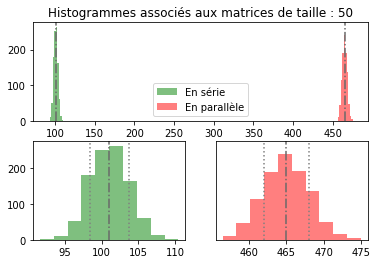

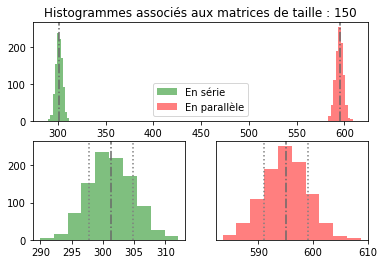

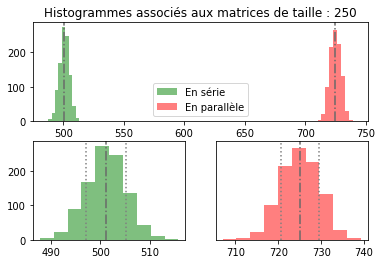

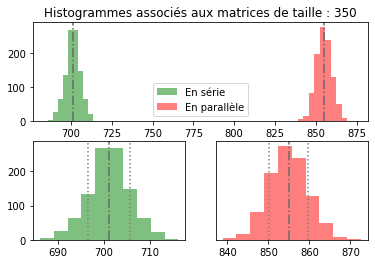

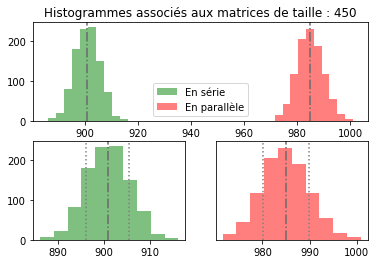

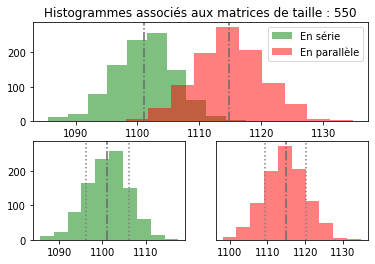

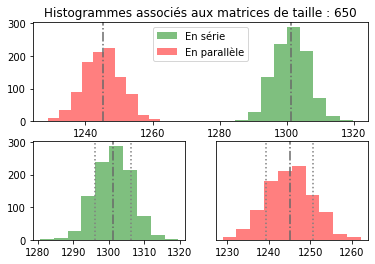

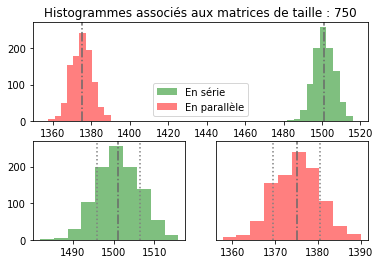

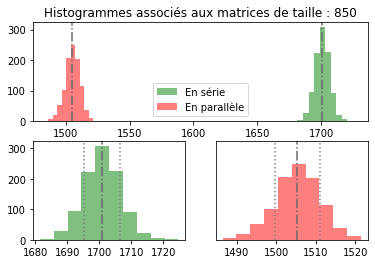

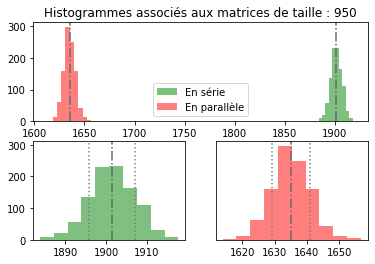

In [171]:
def construct_histo():
    #num = 3
    for size, times in SAMPLES.items():
        serial = []
        parallel = []
        for t1, t2 in zip(times[0], times[1]):
            serial.append(t1)
            parallel.append(t2)
        fig = plot.figure()
        grid = fig.add_gridspec(nrows=2, ncols=2)
        up = fig.add_subplot(grid[:-1, :])
        down_left = fig.add_subplot(grid[-1, :-1])
        down_right = fig.add_subplot(grid[-1, -1], sharey=down_left)
        up.hist(serial, color='green', label='En série', alpha=0.5)
        up.hist(parallel, color='red', label='En parallèle', alpha=0.5)
        up.set_title('Histogrammes associés aux matrices de taille : ' + str(size))
        down_left.hist(serial, color='green', alpha=0.5)
        down_right.hist(parallel, color='red', alpha=0.5)
        down_right.yaxis.set_visible(False)
        up.axvline(MEANS_VAR[size][0], ls='-.', c='dimgrey')
        up.axvline(MEANS_VAR[size][1], ls='-.', c='dimgrey')
        down_left.axvline(MEANS_VAR[size][0], ls='-.', c='dimgrey')
        down_right.axvline(MEANS_VAR[size][1], ls='-.', c='dimgrey')
        down_left.axvline(MEANS_VAR[size][0] - math.sqrt(MEANS_VAR[size][2]), ls=':', c='gray')
        down_right.axvline(MEANS_VAR[size][1] - math.sqrt(MEANS_VAR[size][3]), ls=':', c='gray')
        down_left.axvline(MEANS_VAR[size][0] + math.sqrt(MEANS_VAR[size][2]), ls=':', c='gray')
        down_right.axvline(MEANS_VAR[size][1] + math.sqrt(MEANS_VAR[size][3]), ls=':', c='gray')
        up.legend()
        #plot.savefig('fig_' + str(num) + '.png')
        #num += 1

construct_histo()

Ces histogrammes permettent de tirer de nouvelles conclusions et d'en confirmer d'autres :
* Pour de petites matrices, la technique en série semble meilleure que la technique en parallèle
Par contre, la situation s'inverse ensuite.
* Dans les deux cas, les échantillons paraissent suivre une loi normale.
* Grâce au premier graphique de chaque sous-groupe, il est possible de constater que les moyennes sont différentes.
* Les variances paraissent, à première vue, équivalentes.


## Test d'adéquation

L'hypothèse nulle est que les échantillons suivent une loi normale ou de Gauss.
Les échantillons fournis concernent des variables continues.
C'est pourquoi l'utilisation du test de Kolmogorov-Smirnov parait le plus adéquat.

In [172]:
def kolmogorov_smirnov_test():
    #{int (size) : [float (var série), float (var par), bool (res série), bool (res par)]}
    res = defaultdict(lambda: [float, float, bool, bool])
    for size, times in SAMPLES.items():
        max_val = 0
        for i in range(2):
            f_th = 0
            data = times[i]
            n = len(data)
            xn = empirical_mean(data)
            var = unbiased_variance(data)
            k_s = get_threshold_ks(n)
            for value in data:
                f_n = get_f_n(value, xn, math.sqrt(var))
                f_th += 1 / n
                sub = abs(f_n - f_th)
                max_val = max(max_val, sub)
            res[size][i] = max_val
            res[size][i+2] = max_val < k_s
    return res

def get_threshold_ks(n):
    switcher = {
        0.2 : 1.073,
        0.1 : 1.223,
        0.05 : 1.358,
        0.02 : 1.518,
        0.01 : 1.629
    }
    return switcher[ALPHA]/math.sqrt(n)

def get_f_n(value, xn, sigma):
    normalized = (value - xn) / sigma
    return stats.norm.cdf(normalized)

def print_ks_test():
    test = kolmogorov_smirnov_test()
    builder = " N |   En série   | En parallèle\n"
    builder += "___________________________________\n"
    for size, times in SAMPLES.items():
        builder += str(size)
        builder += " | "
        builder += str(normalize(test[size][0]))
        builder += " "
        builder += str(test[size][2])
        builder += " | "
        builder += str(normalize(test[size][1]))
        builder += " "
        builder += str(test[size][3])
        builder += "\n___________________________________\n"
    print(builder)

print("Test de Kolmogorov-Smirnov avec un alpha de " + str(ALPHA*100) + " %")
print_ks_test()

Test de Kolmogorov-Smirnov avec un alpha de 5.0 %
 N |   En série   | En parallèle
___________________________________
50 | 0.02230 True | 0.02230 True
___________________________________
150 | 0.01960 True | 0.01960 True
___________________________________
250 | 0.02239 True | 0.02239 True
___________________________________
350 | 0.02527 True | 0.02527 True
___________________________________
450 | 0.01271 True | 0.02543 True
___________________________________
550 | 0.02555 True | 0.02555 True
___________________________________
650 | 0.01600 True | 0.01874 True
___________________________________
750 | 0.02471 True | 0.02471 True
___________________________________
850 | 0.01359 True | 0.01988 True
___________________________________
950 | 0.01620 True | 0.01828 True
___________________________________



Le test de Kolmogorv-Smirnov est appliqué pour chaque taille de matrice et aux deux techniques.
Dans tous les cas, il est réussi. Donc les échantillons suivent une loi normale.

## Tests d'équivalence
Maintenant, il faut tester l'équivalence des moyennes ainsi que l'équivalence des variances entre les deux techniques.


### Test de Fisher
Le but de ce test est de vérifier l'équivalence des variances des deux techniques.
Il est à appliquer pour chaque taille de matrice.

In [173]:
def fisher_test():
    res = defaultdict()
    for size, times in SAMPLES.items():
        serial_data = times[0]
        n = len(serial_data)
        parallel_data = times[1]
        m = len(parallel_data)
        serial_var = MEANS_VAR[size][2]
        parallel_var = MEANS_VAR[size][3]
        z = (n / (n - 1)) * serial_var / (m / (m - 1)) *  parallel_var
        if serial_var <= parallel_var:
            z = 1/z
        test = z < stats.f.ppf(ALPHA/2, n-1, m-1)
        res[size] = [serial_var, parallel_var, z, test]
    return res

def print_fisher_test():
    test = fisher_test()
    builder = " N  |      Variances      |   Z    | Rés \n"
    builder += "    |  Série   |   Par    |        | \n"
    builder += "___________________________________________\n"
    for size, times in SAMPLES.items():
        builder += str(size)
        builder += " | "
        builder += str(normalize(test[size][0]))
        builder += " | "
        builder += str(normalize(test[size][1]))
        builder += " | "
        builder += str(normalize(test[size][2]))
        builder += " | "
        builder += str(test[size][3])
        builder += "\n___________________________________________\n"
    print(builder)

print_fisher_test()

 N  |      Variances      |   Z    | Rés 
    |  Série   |   Par    |        | 
___________________________________________
50 | 6.82051 | 9.17421 | 0.01598 | True
___________________________________________
150 | 12.42410 | 16.00747 | 0.00503 | True
___________________________________________
250 | 16.77835 | 19.55174 | 0.00305 | True
___________________________________________
350 | 20.21081 | 22.68524 | 0.00218 | True
___________________________________________
450 | 21.77794 | 24.43889 | 0.00188 | True
___________________________________________
550 | 24.48296 | 30.65197 | 0.00133 | True
___________________________________________
650 | 26.28722 | 31.78537 | 0.00120 | True
___________________________________________
750 | 27.65361 | 29.53000 | 0.00122 | True
___________________________________________
850 | 32.76665 | 32.98573 | 0.00093 | True
___________________________________________
950 | 32.28084 | 34.12907 | 0.00091 | True
___________________________________________



Le test de Fisher est réussi pour l'ensemble des échantillons donc les variances sont équivalentes quelque soit la taille de la matrice.

### Test t de Student
Le but de ce test est de vérifier l'équivalence des moyennes des deux techniques.
Il est à appliquer pour chaque taille de matrice.

In [174]:
def student_test():
    #{int (size) : [float (moy série), float (moy par), float (t), bool (res)]}
    res = defaultdict()
    for size, times in SAMPLES.items():
        serial_data = times[0]
        par_data = times[1]
        mu_1 = MEANS_VAR[size][0]
        mu_2 = MEANS_VAR[size][1]
        s_1 = MEANS_VAR[size][2]
        s_2 = MEANS_VAR[size][3]
        n_1 = len(serial_data)
        n_2 = len(par_data)
        num = mu_1 - mu_2
        denom = math.sqrt((s_1/n_1) + (s_2/n_2))
        t = abs(num / denom)
        f = stats.t.ppf(1-ALPHA/2, n_1+n_2-2)
        res[size] = [mu_1, mu_2, t, t <= f]
    return res

def print_student_test():
    test = student_test()
    builder = " N  |        Moyennes        |     t      | Rés \n"
    builder += "    |   Série   |    Par     |            | \n"
    builder += "________________________________________________\n"
    for size, times in SAMPLES.items():
        builder += str(size)
        builder += " | "
        builder += str(normalize(test[size][0]))
        builder += " | "
        builder += str(normalize(test[size][1]))
        builder += " | "
        builder += str(normalize(test[size][2]))
        builder += " | "
        builder += str(test[size][3])
        builder += "\n________________________________________________\n"
    print(builder)

print_student_test()

 N  |        Moyennes        |     t      | Rés 
    |   Série   |    Par     |            | 
________________________________________________
50 | 101.05876 | 465.04354 | 2878.02781 | False
________________________________________________
150 | 301.26790 | 594.98770 | 1741.93827 | False
________________________________________________
250 | 501.09564 | 725.07361 | 1175.09251 | False
________________________________________________
350 | 701.13480 | 854.90610 | 742.44908 | False
________________________________________________
450 | 900.88976 | 984.96757 | 391.09413 | False
________________________________________________
550 | 1101.11532 | 1114.80906 | 58.31880 | False
________________________________________________
650 | 1301.25933 | 1245.11405 | 232.98480 | False
________________________________________________
750 | 1501.12196 | 1375.00406 | 527.40101 | False
________________________________________________
850 | 1700.83848 | 1505.31920 | 762.48942 | False
________________________

Le test de compatibilité confirme les premières conclusions faites sur base des histogrammes.
En effet, dans aucun cas, les moyennes sont équivalentes.